Tiền xử lý với DBSCAN:

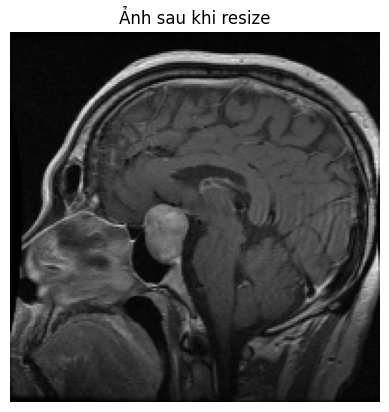

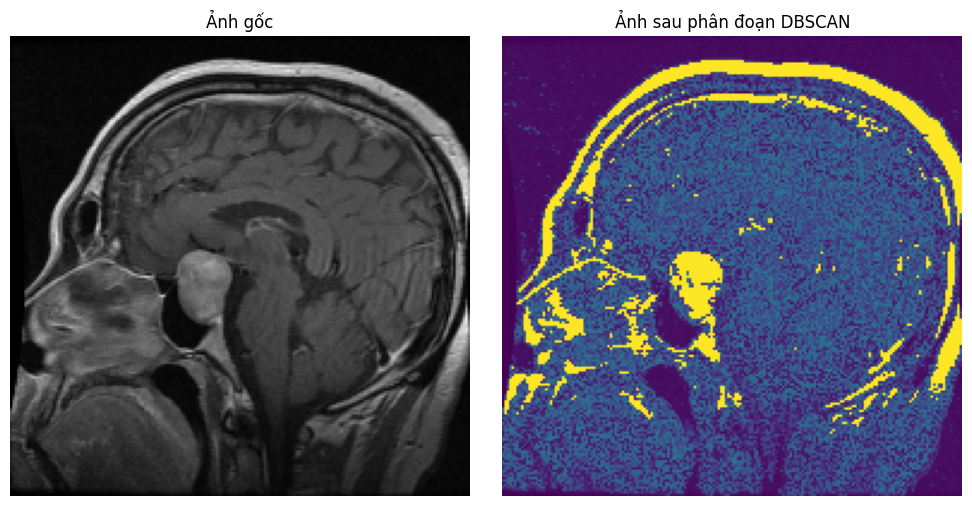

In [3]:
import cv2  
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

# Đọc ảnh
img = cv2.imread(r'D:\Study\8_KPDL\BTL\Brain Tumor Segmentation Dataset\image\3\Tr-pi_0018.jpg')

# Thay đổi kích thước ảnh về 192x192
size = 192
img = cv2.resize(img, (size, size))

# Hiển thị ảnh đã resize
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB
plt.imshow(img_rgb)
plt.title("Ảnh sau khi resize")
plt.axis('off')
plt.show()

# Chuyển sang float32 và định hình lại
Z = np.float32(img.reshape((-1, 3)))
'''
db = DBSCAN(eps=0.3, min_samples=100).fit(Z)

# Hiển thị ảnh gốc và ảnh phân đoạn
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Ảnh gốc')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ảnh sau phân đoạn DBSCAN')
plt.imshow(np.uint8(db.labels_.reshape(img.shape[:2])))
plt.axis('off')

plt.tight_layout()
plt.show()
'''

Tiền xử lý với U-net:

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

# Đường dẫn truy cập dữ liệu
data_path = "Brain Tumor Segmentation Dataset"
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
images = []
masks = []
labels = []
target_size = (128, 128)

# Bước 1: Đọc và tải dữ liệu:
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))
    
    # Bước 2 & 3: Resize ảnh & Chuẩn hóa giá trị pixel:
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        for image_name in tqdm(os.listdir(image_folder), desc=f"Đang tải {class_name}"):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size)  # Thay đổi kích thước hình ảnh
                image = image / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
                
                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)
                
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size)  # Thay đổi kích thước mặt nạ
                    mask = mask / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
                    
                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))
                else:
                    print(f"Mặt nạ bị thiếu cho hình ảnh: {image_name}")

# Bước 4: Thêm chiều kênh:
images = np.array(images).reshape(-1, 128, 128, 1)  # Thêm chiều kênh (channel)
masks = np.array(masks).reshape(-1, 128, 128, 1)    # Thêm chiều kênh (channel)
labels = np.array(labels)

print(f"Số lượng hình ảnh: {len(images)}, Số lượng mặt nạ: {len(masks)}, Số lượng nhãn: {len(labels)}")

# Bước 5: Kiểm tra trực quan (tùy chọn):
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')
plt.xlabel('Các lớp khối u')
plt.ylabel("Số lượng hình ảnh")
plt.title("Phân bố số lượng hình ảnh theo lớp khối u não")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

"""
Nhận xét: Các lớp thể hiện sự phân bố không cân bằng, với lớp "no tumor" chiếm tỷ lệ đáng kể (37.6%), 
trong khi các loại khối u khác có tỷ lệ thấp hơn. Sự mất cân bằng này có thể ảnh hưởng đến hiệu suất của mô hình U-Net.
"""

# Kiểm tra trực quan - Hiển thị ví dụ hình ảnh và mặt nạ trước khi chia dữ liệu
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(12, 10), 
                       gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')
axs[0, 1].text(0.5, 0.5, "Ví dụ 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')
axs[0, 2].text(0.5, 0.5, "Mặt nạ 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')
axs[0, 3].text(0.5, 0.5, "Ví dụ 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')
axs[0, 4].text(0.5, 0.5, "Mặt nạ 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')

for i, class_name in enumerate(classes):
    class_index = classes.index(class_name)
    example_index1 = np.where(labels == class_index)[0][0]  # Ví dụ đầu tiên
    example_index2 = np.where(labels == class_index)[0][min(2, len(np.where(labels == class_index)[0])-1)]  # Ví dụ thứ ba (nếu có)
    image1 = images[example_index1]
    mask1 = masks[example_index1]
    image2 = images[example_index2]
    mask2 = masks[example_index2]
    
    axs[i + 1, 1].imshow(image1.squeeze(), cmap='gray')
    axs[i + 1, 1].axis('off')
    axs[i + 1, 2].imshow(mask1.squeeze(), cmap='gray')
    axs[i + 1, 2].axis('off')
    axs[i + 1, 3].imshow(image2.squeeze(), cmap='gray')
    axs[i + 1, 3].axis('off')
    axs[i + 1, 4].imshow(mask2.squeeze(), cmap='gray')
    axs[i + 1, 4].axis('off')
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')

plt.suptitle("Kiểm tra trực quan: Ví dụ hình ảnh và mặt nạ theo lớp", fontsize=14)
plt.tight_layout()
plt.show()

# Bước 6: Chia tập dữ liệu thành tập huấn luyện và tập xác thực
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True
)

print(f"Bộ dữ liệu huấn luyện - Hình ảnh: {images_train.shape}, Mặt nạ: {masks_train.shape}, Nhãn: {labels_train.shape}")
print(f"Bộ dữ liệu xác thực - Hình ảnh: {images_val.shape}, Mặt nạ: {masks_val.shape}, Nhãn: {labels_val.shape}")

# Bước 7: Kiểm tra trực quan sau khi chia  (tùy chọn):
def plot_split_distribution(labels_train, labels_val, classes):
    train_counts = np.bincount(labels_train)
    val_counts = np.bincount(labels_val)
    class_labels = [classes[i] for i in range(len(classes))]
    
    x = np.arange(len(classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, train_counts, width, label='Huấn luyện', color='#E17A8A')
    ax.bar(x + width/2, val_counts, width, label='Xác thực', color='#8AC6E1')
    
    ax.set_xlabel('Các lớp khối u')
    ax.set_ylabel('Số lượng hình ảnh')
    ax.set_title('Phân bố dữ liệu sau khi chia thành tập huấn luyện và xác thực')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=45)
    ax.legend()
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

plot_split_distribution(labels_train, labels_val, classes)

# Bước 8: Tạo generator tăng cường dữ liệu
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    
    while True:
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield img_batch, mask_batch

# Bước 9: Kiểm tra trực quan sau tăng cường (tùy chọn): 
def plot_images(images, masks, num_images=5, title="Hình ảnh và mặt nạ"):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title(f'Hình ảnh {i+1}')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title(f'Mặt nạ {i+1}')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Kiểm tra dữ liệu gốc trước tăng cường
plot_images(images_train[:5], masks_train[:5], num_images=5, title="Kiểm tra trực quan: Dữ liệu gốc trước tăng cường")

# Kiểm tra dữ liệu sau tăng cường từ generator
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))
plot_images(images_batch, masks_batch, num_images=5, title="Kiểm tra trực quan: Dữ liệu sau tăng cường")


SyntaxError: invalid syntax (960517140.py, line 56)